In [127]:
from IPython.display import display, HTML
display(HTML("<style>.container {width:80% !important;}</style>"))

### Import libraries

In [128]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import polar
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from IPython.display import Image
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt

pd.options.plotting.backend = 'plotly'
pio.templates["standard"] = go.layout.Template(layout=dict(
    title_font_family = 'Courier',
    font_size = 20,
    margin = dict(t=50, b=0, l=50, r=0),
    yaxis_nticks = 4,
    xaxis_nticks = 5,
    legend_title = '',
    legend_font_family = 'Courier',
    legend_orientation = 'v',
    legend_xanchor = 'right',
    legend_bgcolor = 'rgba(256,256,256,0.8)',
    legend_x = 1,
    legend_y = 1.15,
    width = 1150, 
    height = 500)
)
colors = px.colors.qualitative.Plotly
pio.templates.default = 'simple_white+standard'

T = 2
F = np.kron(np.eye(2), np.array([[1, T], [0, 1]]))
G = np.kron(np.eye(2), np.array([T**2/2, T])).T
sigmaA = .3
sigmaD = 50
sigmaB1 = .004
sigmaB2 = .001
sigmas = np.array([sigmaD, sigmaB1, sigmaB2])

### #1, 2, 3, 4. Generate true trajectory and measurements

In [129]:
def state_equation(sample_size=500, X0=1000, V0_x=100, Y0=1000, V0_y=100):
    # Initialize Cartesian coordinates
    X_vector_c = np.array([np.zeros(sample_size)] * 4)
    X_vector_c[:, 0] = np.array([X0, V0_x, Y0, V0_y])

    # Initialize Polar coordinates
    X_vector_p = np.array([np.zeros(sample_size)] * 2)
    D0 = np.sqrt(X0**2 + Y0**2)
    beta0 = np.arctan2(X0, Y0)
    X_vector_p[:, 0] = np.array([D0, beta0])

    for i in range(1, sample_size):
        # calculate state equation with Cartesian coordinates
        X_vector_c[:, i] = F@X_vector_c[:, i-1] + G@np.random.normal(scale=sigmaA, size=2)

        # calculate state equation with Polar coordinates
        D = np.sqrt(X_vector_c[0, i]**2 + X_vector_c[2, i]**2)
        beta = np.arctan2(X_vector_c[0, i], X_vector_c[2, i])
        X_vector_p[:, i] = np.array([D, beta])

    return X_vector_c, X_vector_p

def measurement_equation(X_p, sigmas):
    Z_p = np.zeros((2, X_p.shape[1]))
    Z_c_pseudo_vector = Z_p.copy()

    for i in range(0, X_p.shape[1], 2):
        # Calculate measurements for Polar coordinates
        Z_D = X_p[0, i] + np.random.normal(scale=sigmas[0])
        Z_beta = X_p[1, i] + np.random.normal(scale=sigmas[1])
        Z_p[:, i] = np.array([Z_D, Z_beta])

        # Calculate pseudo-measurement vector
        x_m = Z_D * np.sin(Z_beta)
        y_m = Z_D * np.cos(Z_beta)
        Z_c_pseudo_vector[:, i] = np.array([x_m, y_m])

    for i in range(1, X_p.shape[1], 2):
        Z_p[1, i] = X_p[1, i] + np.random.normal(scale=sigmas[2])

    return Z_p, Z_c_pseudo_vector

### Figure 1. True trajectory and measurments

In [130]:
X_vector_c, X_vector_p = state_equation()
Z_p, Z_c_pseudo_vector = measurement_equation(X_vector_p, sigmas)

fig = go.Figure()
colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = X_vector_c[0, :], y = X_vector_c[2, :], line_color = colors[9], name="Trajectory"))
fig.add_trace(go.Scatter(x = Z_c_pseudo_vector[0, :], y = Z_c_pseudo_vector[1, :], line_color = colors[0], mode="markers", name="Measurments"))

fig.update_layout(title='Motion', xaxis_title='<b>x</b>',yaxis_title = "<b>y</b>")
fig.show()
fig.write_image("Trajectory.png", format = 'png', width = 1150, height = 500, scale = 2)

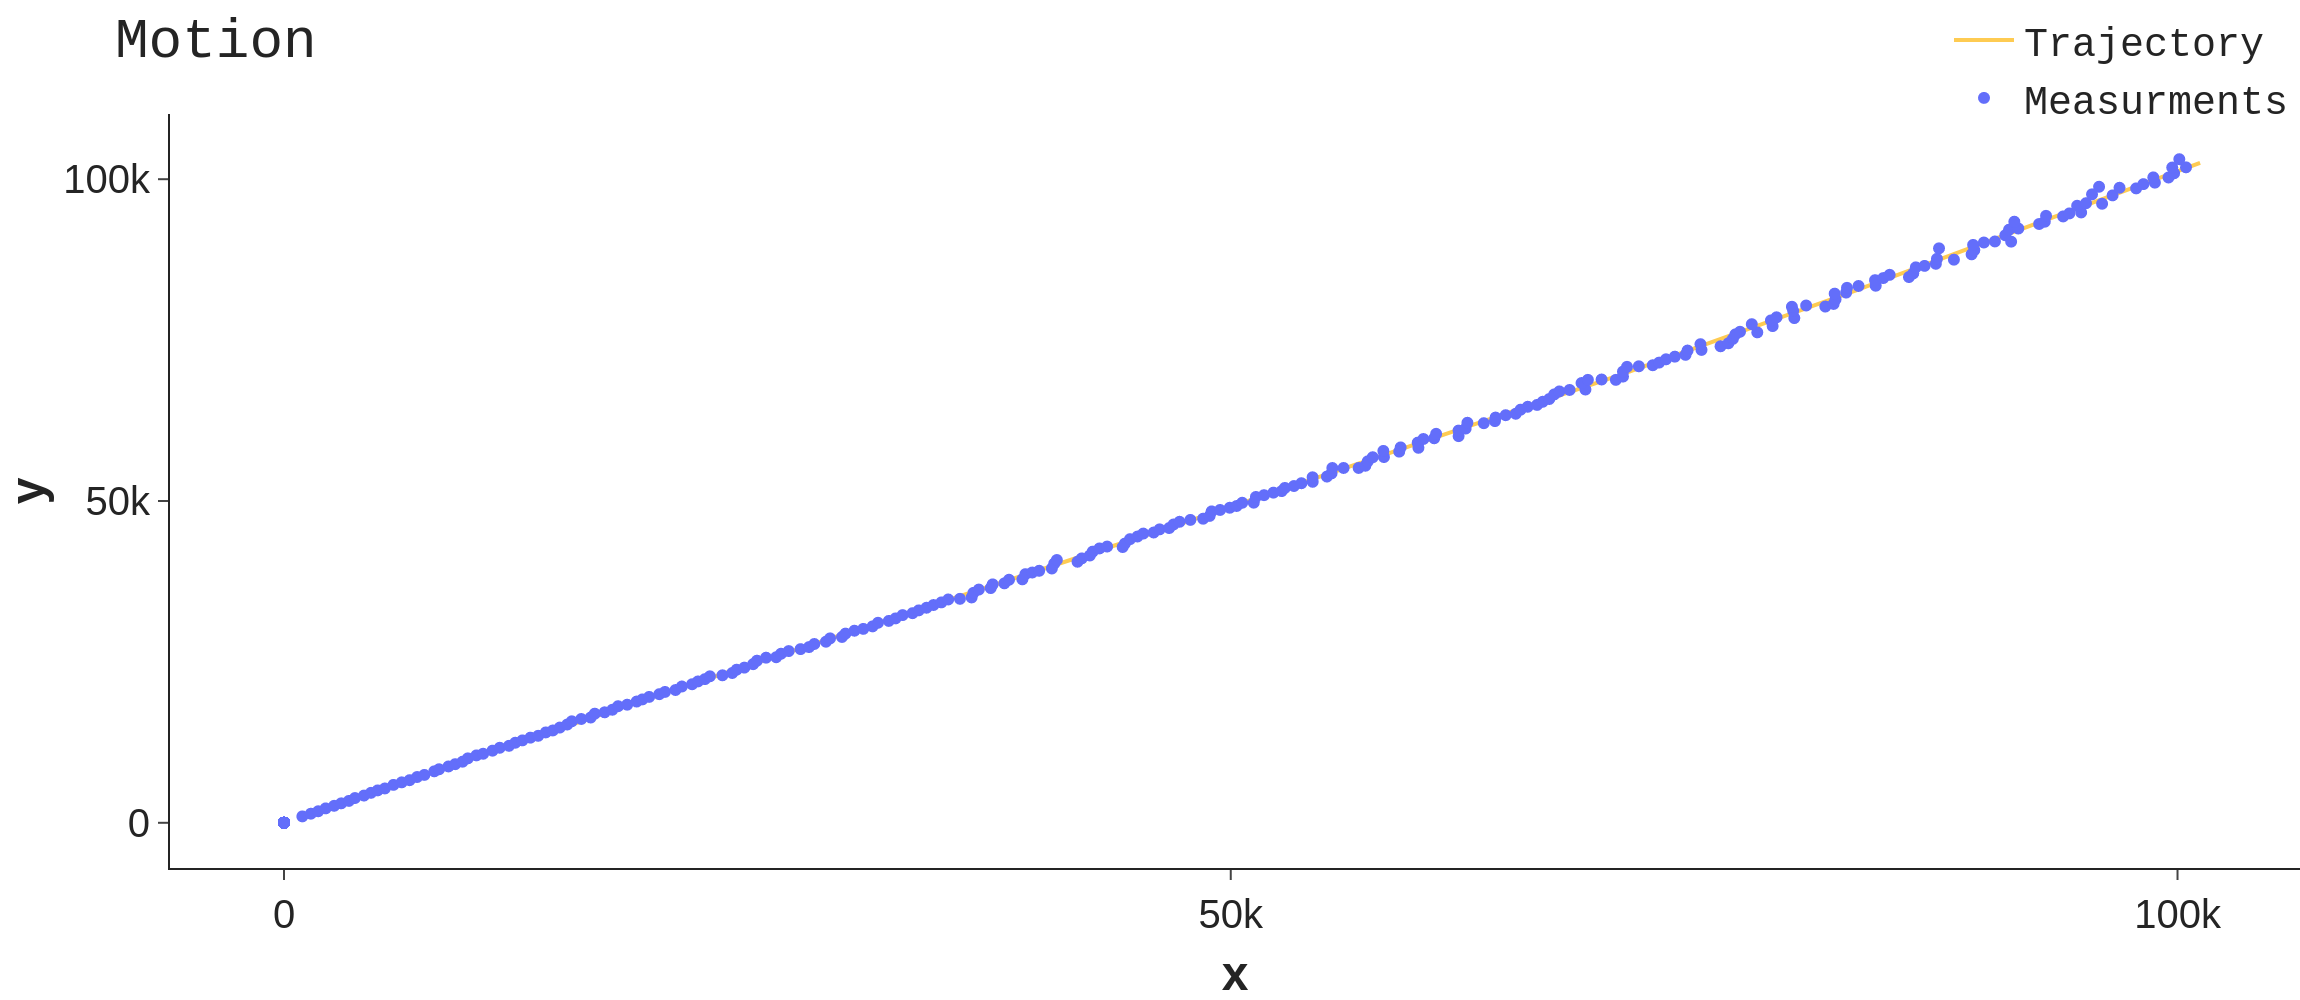

In [170]:
Image("Trajectory.png")

### #5. Extended Kalman filter algorithm

In [147]:
def EKF(Z, Rs, Q, sample_size, X0, P0_0_diag = 10**4):
    # Initial zeros values for Cartesian coordinates
    X_filtered_c = np.zeros((4, sample_size))
    X_extrapol_c = np.zeros((4, sample_size))
    # Initial zeros values for Polar coordinates
    X_filtered_p = np.zeros((2, sample_size))
    X_extrapol_p = np.zeros((2, sample_size))
    # Initial filtered estimates
    X_filtered_c[:, 0] = X0
    X_extrapol_c[:, 0] = X_filtered_c[:, 0]
    X_filtered_p[:, 0] = np.array([np.sqrt(X0[0]**2 + X0[2]**2), np.arctan2(X0[0], X0[2])])
    X_extrapol_p[:, 0] = X_filtered_p[:, 0]
    # Initial filtration error covariance matrix
    P0 = np.eye(X_filtered_c.shape[0]) * P0_0_diag
 
    # Initial Filter gain K
    K_gain_p = np.array([np.zeros((4, 2))] * sample_size)

    # Implement Kalman update equations
    for i in range(1, sample_size):
        X_pred = F@X_filtered_c[:, i-1]

        # Translate values to Polar coordinates after prediction of state vector X_pred
        X_D = np.sqrt(X_pred[0]**2 + X_pred[2]**2)
        X_beta = np.arctan2(X_pred[0], X_pred[2])  
        X_extrapol_p[:, i] = np.array([X_D, X_beta])

        ss = X_pred[0]**2+X_pred[2]**2
        H_g = np.array([np.sqrt(ss), np.arctan2(X_pred[0], X_pred[2])])
        dH_g = np.array([[X_pred[0]/np.sqrt(ss), 0, X_pred[2]/np.sqrt(ss), 0], [X_pred[2]/ss, 0, -X_pred[0]/ss, 0]])

        # Continue
        P_pred = F@P0@F.T + Q
        if i%2:
            H = H_g[1]
            dH = dH_g[1, :]
            R = Rs[1]
            a = 1/(dH@P_pred@dH.T + R)
            z = Z[:, i][1]
        else:
            H = H_g
            dH = dH_g
            R = Rs[0]
            a = np.linalg.inv(dH@P_pred@dH.T + R)
            z = Z[:, i]
        K = P_pred@dH.T.dot(a)
        X_filtered_c[:, i] = X_pred + K.dot(z - H)
        P0 = P_pred - K.dot(dH@P_pred)

        # Translate values to Polar coordinates after filtration of state vector X
        X_D = np.sqrt(X_filtered_c[0, i]**2 + X_filtered_c[2, i]**2)
        X_beta = np.arctan2(X_filtered_c[0, i], X_filtered_c[2, i])  
        X_filtered_p[:, i] = np.array([X_D, X_beta])

#         K_gain_p[i] = K

    return X_filtered_p, X_extrapol_p, K_gain_p, X_filtered_c

### Initial filter parameters

In [148]:
x2 = X_vector_c[:, 2]
x0 = X_vector_c[:, 0]
X0 = np.array([x2[0], (x2[0]-x0[0])/2/T, x2[2], (x2[2]-x0[2])/2/T])

In [149]:
Rs = (np.eye(2)*sigmas[:-1], sigmas[-1])
Q = G@G.T*sigmaA**2
X_filtered_p, X_extrapol_p, K_gain_p, X_filtered_c = EKF(Z_p, Rs, Q, 500, X0)

### Figure 2. True trajectory, measurements and Filtered estimates

In [173]:
fig = go.Figure()
colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = X_filtered_c[0, :], y = X_filtered_c[2, :], line_color = colors[1], name="Filtered Trajectory"))
fig.add_trace(go.Scatter(x = X_vector_c[0, :], y = X_vector_c[2, :], line_color = colors[9], name="True Trajectory"))
fig.add_trace(go.Scatter(x = Z_c_pseudo_vector[0, :], y = Z_c_pseudo_vector[1, :], line_color = colors[0], mode="markers", name="Measurments"))

fig.update_layout(title='Motion', xaxis_title='<b>x</b>',yaxis_title = "<b>y</b>")
fig.show()
fig.write_image("Filtered.png", format = 'png', width = 1150, height = 500, scale = 2)

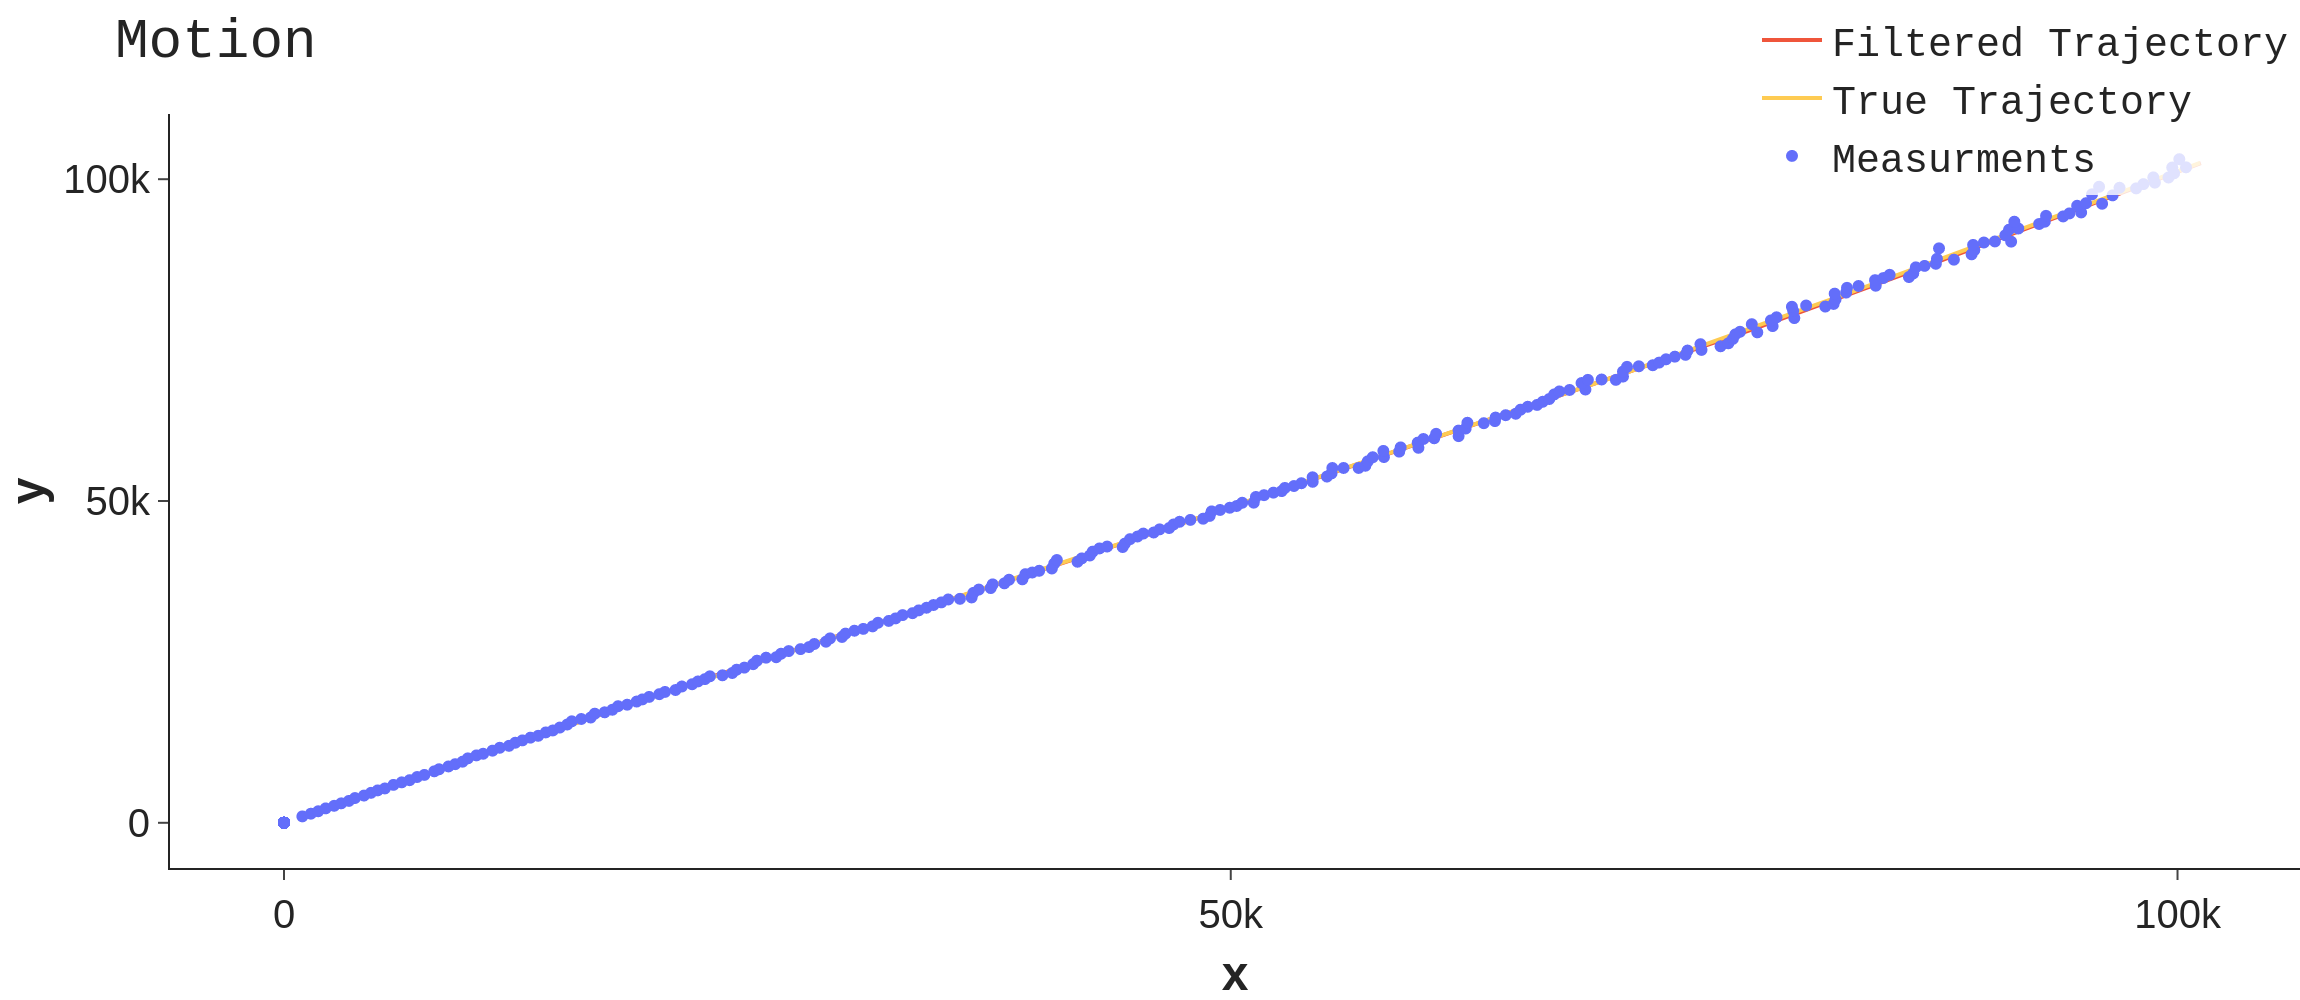

In [174]:
Image("Filtered.png")

### #7. Errors of extrapolation and filtration estimates

In [163]:
def final_error(P0_0_diag, Q, sample_size=500, M=500):
    Error_true_filtered = np.zeros((2, sample_size))
    Error_true_extrapol = np.zeros((2, sample_size))
    Error_measured = np.zeros((2, sample_size))
    for i in range(M):
        X_vector_c, X_vector_p = state_equation()
        Z_p, Z_c_pseudo_vector = measurement_equation(X_vector_p, sigmas)
        X_filtered_p, X_extrapol_p, K_gain_p, X_filtered_c = EKF(Z_p, Rs, Q, sample_size, X0)
        Error_true_filtered += (X_vector_p - X_filtered_p) ** 2
        Error_true_extrapol += (X_vector_p - X_extrapol_p) ** 2
        Error_measured += (Z_p - X_vector_p) ** 2

    return np.sqrt(Error_true_filtered / (M - 1)), np.sqrt(Error_true_extrapol / (M - 1)), np.sqrt(Error_measured / (M - 1))

In [168]:
RMSE_true_filtered, RMSE_true_extrapol, Error_measured = final_error(10**10, Q)

In [169]:
from plotly.subplots import make_subplots

fig = make_subplots(rows = 1, cols = 2, horizontal_spacing = 0.07, subplot_titles= ["<b>D</b>", "<b>\u03b2</b>"])
x=np.arange(500)
fig.add_trace(go.Scatter(x = x, y = RMSE_true_filtered[0, :], name = 'filtered', line_color = colors[0]), row = 1, col = 1)
fig.add_trace(go.Scatter(x = x, y = RMSE_true_filtered[1, :], name = 'filtered', line_color = colors[0], showlegend = False), row = 1, col = 2)
fig.add_trace(go.Scatter(x = x, y = RMSE_true_extrapol[0, :], name = 'extrapolated', line_color = colors[2]), row = 1, col = 1)
fig.add_trace(go.Scatter(x = x, y = RMSE_true_extrapol[1, :], name = 'extrapolated', line_color = colors[2], showlegend = False), row = 1, col = 2)
fig.add_trace(go.Scatter(x = x[::2], y = Error_measured[0, :][::2], name = '1st observer measurments', line_color = colors[1]), row = 1, col = 1)
fig.add_trace(go.Scatter(x = x[::2], y = Error_measured[1, :][::2], name = '1st observer measurments', line_color = colors[1], showlegend = False), row = 1, col = 2)
fig.add_trace(go.Scatter(x = x[1::2], y = Error_measured[1, :][1::2], name = '2d observer measurments', line_color = colors[3], showlegend = False), row = 1, col = 2)

fig.update_xaxes(mirror = True)
fig.update_yaxes(mirror = True)

fig.update_annotations(font_size = 30, font_family = "Courier")
fig.update_layout(title = "<b>RMSE</b>",
                  xaxis_title = "\u2800                                                                           step#",
                  yaxis_title = "\u03c3",
                  xaxis2_title = "",
                  yaxis2_title = "",
                  margin_t = 50,
                  legend_y = 1)

fig.show()
fig.write_image("RMSE.png", format = 'png', width = 1150, height = 500, scale = 2)

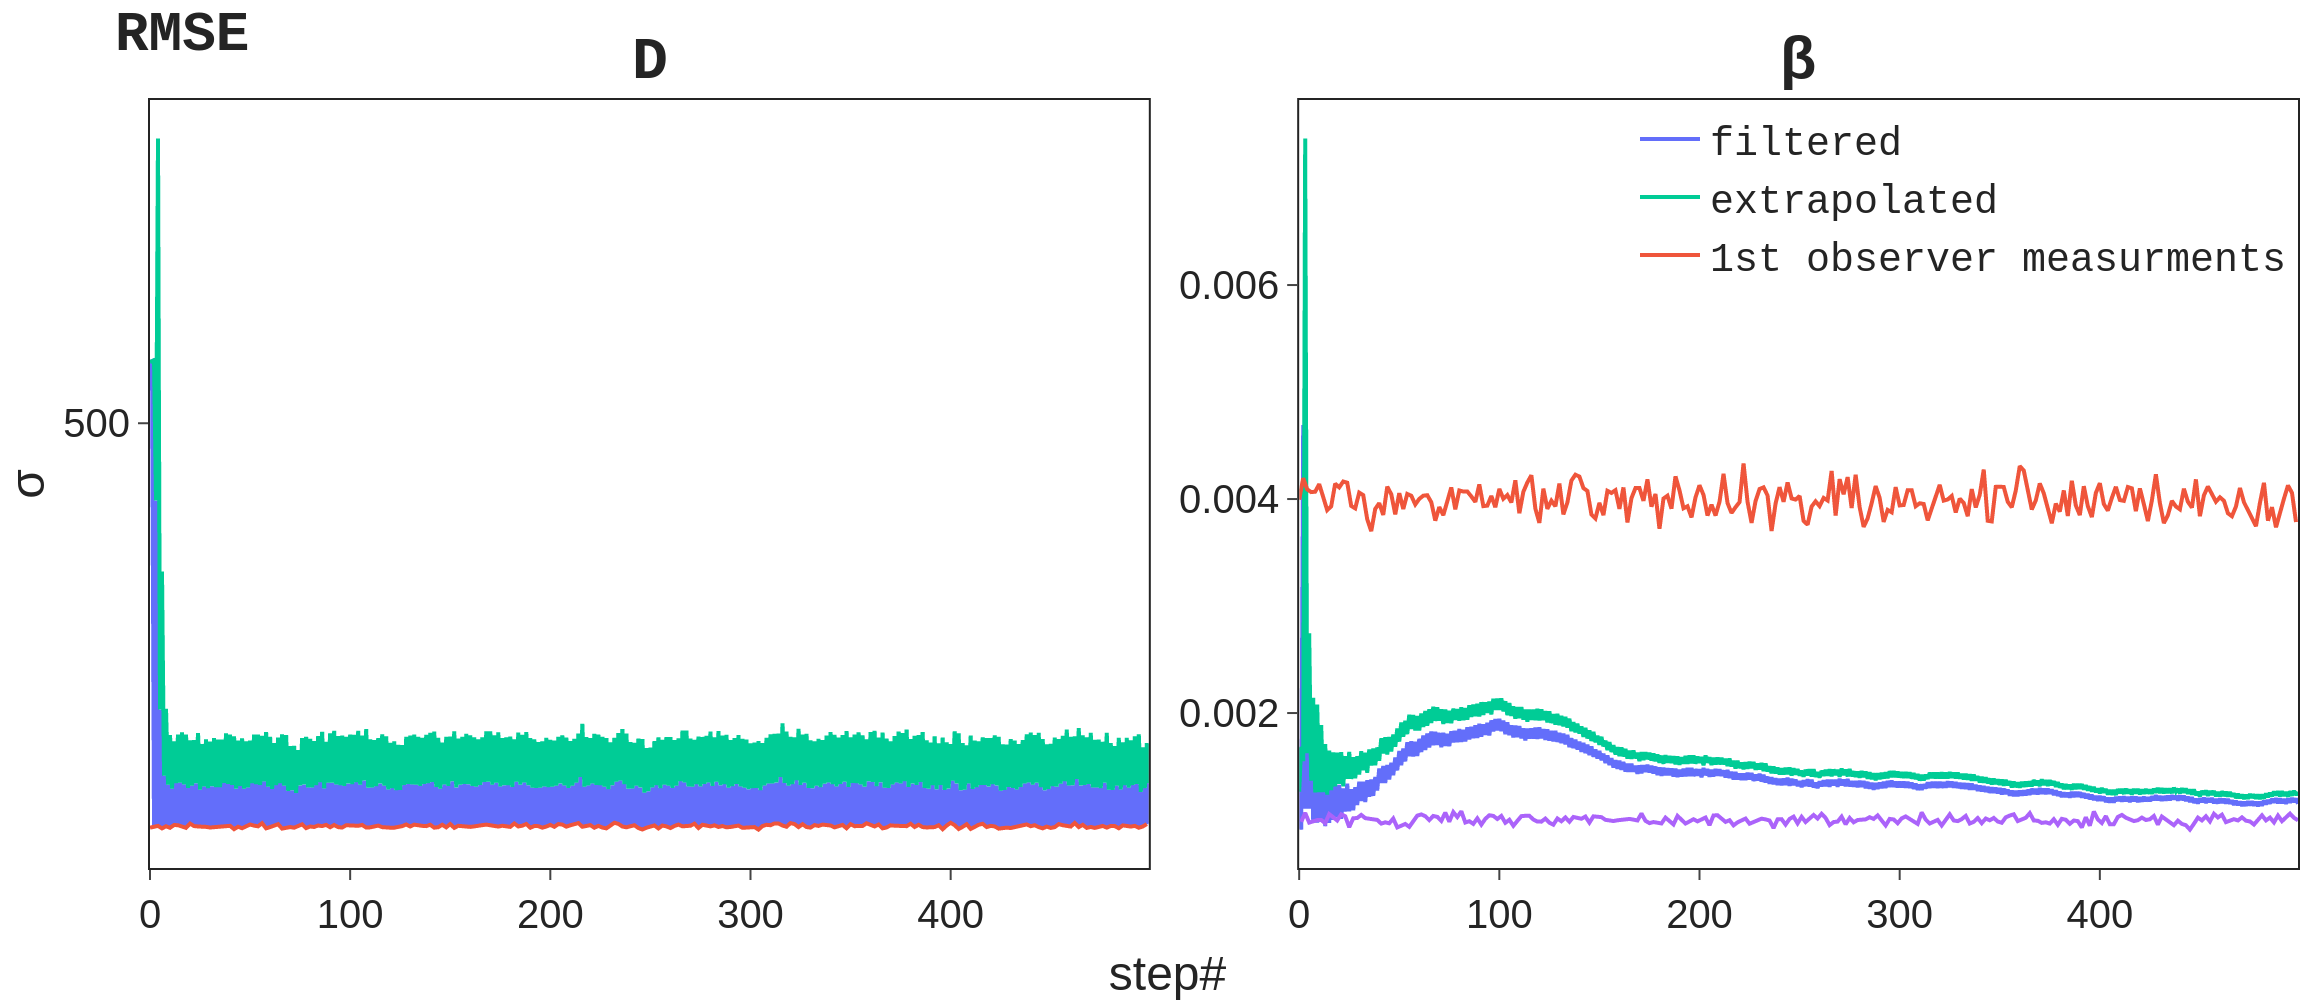

In [175]:
Image("RMSE.png")

# Conclusion

We have learned joint assimilation of navigation data coming from different sources. Assimilation of navigation data leads to the increase of estimation errors. In other words, Kalman algorithm could not filter the data and becomes even more noisy than the measurements noise. 
In case of azimuth noise, Kalman algorithm can filter more noisy azimuth measurements from first observer, but can not filter the measurements lower than the more accurate azimuth measurements from second observer.
It shows that Kalman Filter algorithm can not manage with joint assimilation of navigation data coming from different sources with different measurements noise.